In [2]:
import torch
torch.manual_seed(10)
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn import decomposition
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import nltk
#Import stopwords
from nltk.corpus import stopwords

In [3]:
corpus = [
    'drink milk',
    'drink cold water',
    'drink cold cola',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat apple',
    'juice with sugar',
    'cola with sugar',
    'mango is fruit',
    'apple is fruit',
    'cherry is fruit',
    'Berlin is Germany',
    'Boston is USA',
    'Mercedes from Germany',
    'Mercedes is a car',
    'Ford from USA',
    'Ford is a car'
]

In [13]:
def create_vocabulary(corpus):
    '''Creates a dictionary with all unique words in corpus with id'''
    vocabulary = {}
    i = 0
    for sentence in corpus:
        for word in sentence.split():
            if word not in vocabulary:
                vocabulary[word] = i
                i+=1
    return vocabulary

def prepare_set(corpus, window = 1):
    '''Creates a dataset with Input column and Outputs columns for neighboring words. 
       The number of neighbors = window*2'''
    columns = ['Input'] + [f'Output{i+1}' for i in range(window*2)]
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = [w]
            out = []
            for n in range(1,window+1):
                # look back
                if (i-n)>=0:
                    out.append(sentence.split()[i-n])
                else:
                    out.append('<padding>')
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out.append(sentence.split()[i+n])
                else:
                    out.append('<padding>')
            row = pd.DataFrame([inp+out], columns = columns)
            result = pd.concat([result, row], ignore_index = True)

    return result

def prepare_set_ravel(corpus, window = 1):
    '''Creates a dataset with Input column and Output column for neighboring words. 
       The number of neighbors = window*2'''
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = w
            for n in range(1,window+1):
                # look back
                if (i-n)>=0:
                    out = sentence.split()[i-n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = pd.concat([result, row], ignore_index = True)
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out = sentence.split()[i+n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = pd.concat([result, row], ignore_index = True)
    return result

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
 
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    result = []
    for i in corpus:
        out = nltk.word_tokenize(i)
        out = [x.lower() for x in out]
        out = [x for x in out if x not in stop_words]
        result.append(" ". join(out))
    return result

corpus = preprocess(corpus)
corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['drink milk',
 'drink cold water',
 'drink cold cola',
 'drink juice',
 'drink cola',
 'eat bacon',
 'eat mango',
 'eat cherry',
 'eat apple',
 'juice sugar',
 'cola sugar',
 'mango fruit',
 'apple fruit',
 'cherry fruit',
 'berlin germany',
 'boston usa',
 'mercedes germany',
 'mercedes car',
 'ford usa',
 'ford car']

In [8]:
vocabulary = create_vocabulary(corpus)
vocabulary

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'bacon': 7,
 'mango': 8,
 'cherry': 9,
 'apple': 10,
 'sugar': 11,
 'fruit': 12,
 'berlin': 13,
 'germany': 14,
 'boston': 15,
 'usa': 16,
 'mercedes': 17,
 'car': 18,
 'ford': 19}

In [14]:
train_emb = prepare_set(corpus, window = 2)
train_emb.head()

,Input,Output1,Output2,Output3,Output4
0,drink,<padding>,milk,<padding>,<padding>
1,milk,drink,<padding>,<padding>,<padding>
2,drink,<padding>,cold,<padding>,water
3,cold,drink,water,<padding>,<padding>
4,water,cold,<padding>,drink,<padding>


In [15]:
train_emb = prepare_set_ravel(corpus, window = 2)
train_emb.head()

,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,drink,water
4,cold,drink


In [16]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,0,1
1,1,0
2,0,2
3,0,3
4,2,0


In [19]:
vocab_size = len(vocabulary)

def get_input_tensor(tensor):
    '''Transform 1D tensor of word indexes to one-hot encoded 2D tensor'''
    size = [*tensor.shape][0]
    inp = torch.zeros(size, vocab_size).scatter_(1, tensor.unsqueeze(1), 1.)
    return Variable(inp).float()

In [22]:
embedding_dims = 5
device = torch.device('cpu')

In [23]:
initrange = 0.5 / embedding_dims
W1 = Variable(torch.randn(vocab_size, embedding_dims, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) # shape V*H
W2 = Variable(torch.randn(embedding_dims, vocab_size, device=device).uniform_(-initrange, initrange).float(), requires_grad=True) #shape H*V
print(f'W1 shape is: {W1.shape}, W2 shape is: {W2.shape}')

W1 shape is: torch.Size([20, 5]), W2 shape is: torch.Size([5, 20])


In [24]:
num_epochs = 2000
learning_rate = 2e-1
lr_decay = 0.99
loss_hist = []

In [25]:
%%time
for epo in range(num_epochs):
    for x,y in zip(DataLoader(train_emb.Input.values, batch_size=train_emb.shape[0]), DataLoader(train_emb.Output.values, batch_size=train_emb.shape[0])):
        
        # one-hot encode input tensor
        input_tensor = get_input_tensor(x) #shape N*V
     
        # simple NN architecture
        h = input_tensor.mm(W1) # shape 1*H
        y_pred = h.mm(W2) # shape 1*V
        
        # define loss func
        loss_f = torch.nn.CrossEntropyLoss() 
        
        #compute loss
        loss = loss_f(y_pred, y)
        
        # bakpropagation step
        loss.backward()
        
        # Update weights using gradient descent.
        with torch.no_grad():
            W1 -= learning_rate*W1.grad.data
            W2 -= learning_rate*W2.grad.data
            # zero gradients for next step
            W1.grad.data.zero_()
            W1.grad.data.zero_()
    if epo%10 == 0:
        learning_rate *= lr_decay
    loss_hist.append(loss)
    if epo%50 == 0:
        print(f'Epoch {epo}, loss = {loss}')

Epoch 0, loss = 2.998577833175659
Epoch 50, loss = 2.625443696975708
Epoch 100, loss = 1.2810331583023071
Epoch 150, loss = 1.0042035579681396
Epoch 200, loss = 0.9315589070320129
Epoch 250, loss = 1.0318917036056519
Epoch 300, loss = 1.1486632823944092
Epoch 350, loss = 1.1281176805496216
Epoch 400, loss = 1.1822351217269897
Epoch 450, loss = 1.2760839462280273
Epoch 500, loss = 1.2170182466506958
Epoch 550, loss = 1.2143076658248901
Epoch 600, loss = 1.370565414428711
Epoch 650, loss = 1.3514999151229858
Epoch 700, loss = 1.1552225351333618
Epoch 750, loss = 1.3594317436218262
Epoch 800, loss = 1.1826564073562622
Epoch 850, loss = 1.1660782098770142
Epoch 900, loss = 1.0774011611938477
Epoch 950, loss = 1.0286988019943237
Epoch 1000, loss = 1.0183576345443726
Epoch 1050, loss = 1.0019303560256958
Epoch 1100, loss = 0.9809491634368896
Epoch 1150, loss = 0.9596195220947266
Epoch 1200, loss = 0.9413356781005859
Epoch 1250, loss = 0.9264590740203857
Epoch 1300, loss = 0.9201663136482239


In [26]:
W1 = W1.detach().numpy()
W2 = W2.T.detach().numpy()

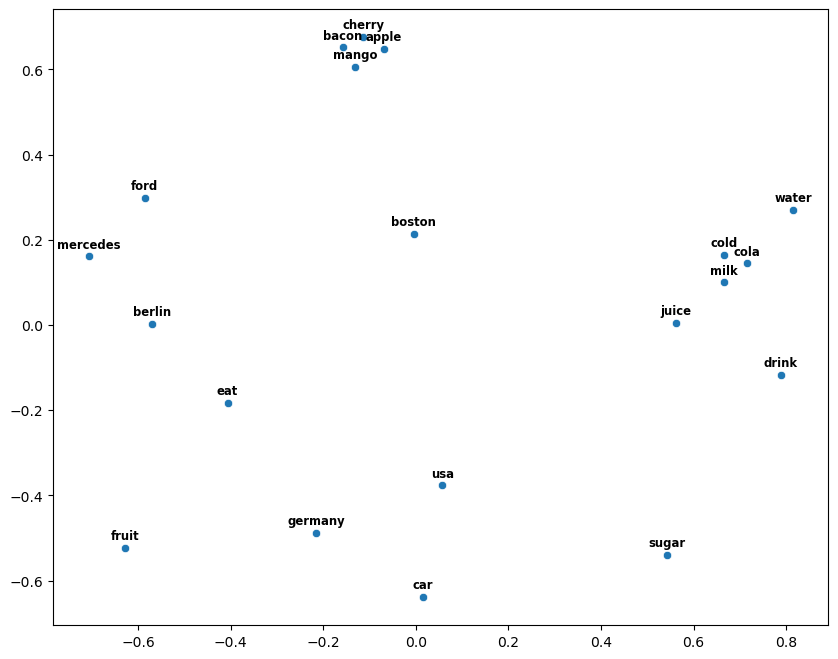

In [28]:
svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1)
x = W1_dec[:,0]
y = W1_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

for i in range(0,W1_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');

In [31]:
W2_dec = svd.fit_transform(W2)
x1 = W2_dec[:,0]
y1 = W2_dec[:,1]
plot1 = sns.scatterplot(x1=x1, y1=y1)
for i in range(0,W2_dec.shape[0]):
     plot1.text(x1[i], y1[i]+1, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');

ValueError: Image size of 164606x137902 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x800 with 1 Axes>